# Analiza modelu stanowego - przypadek skalarny

Chociaż w zadaniu będziemy sprawdzać przypadek jednowymiarowy, model stanowy w ogólności znajduje zastosowanie do analizowania szerokiego spektrum obiektów, jak drony, roboty kroczące czy układy chemiczne. Chociaż wiele interesujących układów jest nieliniowych (chociażby najprostsze wahadło), można je analizować poprzez linearyzację w punkcie pracy albo względem trajektorii. W tym zadaniu jak i kolejnym skupimy się na układach liniowych niskiego rzędu, jednak metody znajdą zastosowanie dla bardziej złożonych obiektów.

Realizacja ćwiczenia polega na uzupełnienie kodu w liniach z umeiszcoznmym napisem *TODO:*
oraz krótkiej odpowiedzi na pytania w polach *ODPOWIEDŹ*.

In [12]:
import time

import numpy as np
import pydot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from IPython.display import SVG, display

from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem, LogVectorOutput
from pydrake.systems.analysis import Simulator, ExtractSimulatorConfig, ApplySimulatorConfig
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.geometry import StartMeshcat, Sphere, Box, Cylinder
from pydrake.math import RigidTransform, RotationMatrix

### Zadanie 1. Analiza zachowania układu opisanego modelem stanowym
#### 1.1 Załóżmy, że funkcja $x(t)$ określa poziom naładowania baterii telefonu. Mając układ liniowy, określający zachowanie (zmiany) poiomu naładowania, o równaniu dynamiki

$\dot{x} = ax$ dla $a \in \mathbb{R}$

oraz warunek brzegowy

$x_0 = 5.0$

dobierz parametr **a** tak aby uzyskać trzy różne jakościowo (w sposobie zachowania) przebiegi stanu układu dla $t \in (0, 10)$.

In [13]:
def create_system(x_0, a):
    def plot():
        log = logger.FindLog(context)
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('x(t)')

    # DiagramBuilder - like Simulink but without GUI
    builder = DiagramBuilder()

    x = Variable('x')
    continuous_vector_system = SymbolicVectorSystem(state=[x], dynamics=[a * x], output=[x])
    system = builder.AddSystem(continuous_vector_system)
    logger= LogVectorOutput(system.get_output_port(0), builder)

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    context.SetContinuousState([x_0])

    return diagram, context, plot

def analytical_solution(x_0, a, t):
    z = np.einsum('i, j -> ij', a, t)
    return x_0*np.exp(z)

Podpowiedź: mając rozwiązanie równania dynamiki dla modelu stanowego ($x(t)$) możemy określić odpowiedź dla każdej chwili czasu. Zgadując (albo całkując obustronnie równanie stanu po rozdzieleniu zmiennych), że rozwiązaniem jest $x(t) = x_0e^{at}$ możemy sprawdzić, że faktycznie $\dot{x}=ax_0e^{at}=ax(t)$ oraz $x(0) = x_0e^{0}=x_01=x_0$. Mając analityczną odpowiedź układu i tylko jeden parametr do wyboruu, możemy zwizualizować przebiegi dla różnych wartości parametru. W tym celu można skorzystać z kodu poniżej.

Text(0.5, 0, 'x(t)')

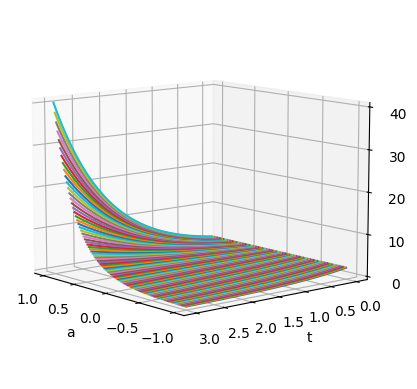

In [14]:
x_0 = 2
a_space = np.linspace(-1,1,100) # TODO: zmień na przedział od -1 do 1 i 100 próbek, można skorzystać numpy.linspace
t = np.linspace(0,3, 100) # TODO: zmień na przedział (0, 3) i 100 próbek
X_t = analytical_solution(x_0, a_space, t)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(X_t.shape[0]):
    ax.plot(a_space[i] * np.ones_like(t), t, X_t[i])
ax.view_init(elev=10., azim=140)
ax.set_xlabel('a')
ax.set_ylabel('t')
ax.set_zlabel('x(t)')

Text(0.5, 1.0, 'Numerical solution form simulator x(t)')

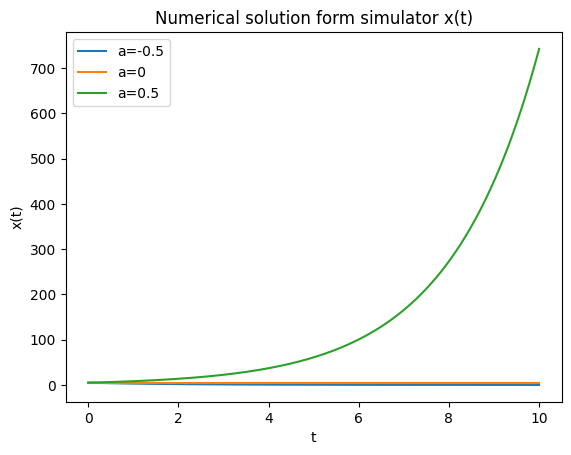

In [15]:
x_0 = 5.0
a_lst = [-0.5, 0, 0.5] # TODO: ustaw 3 wartości uzyskując 3 rózne jakościowo przebiegi
T = 10.0 # simulation time [seconds]
for a in a_lst:
    diagram, context, plot = create_system(x_0=x_0, a=a)
    simulator = Simulator(diagram, context)
    simulator.AdvanceTo(T)
    plot()
plt.legend(list(map(lambda a: f'a={a}', a_lst)))
plt.title('Numerical solution form simulator x(t)')

Porównaj z analitycznym rozwiązaniem

Text(0.5, 1.0, 'Analytical solution x(t)')

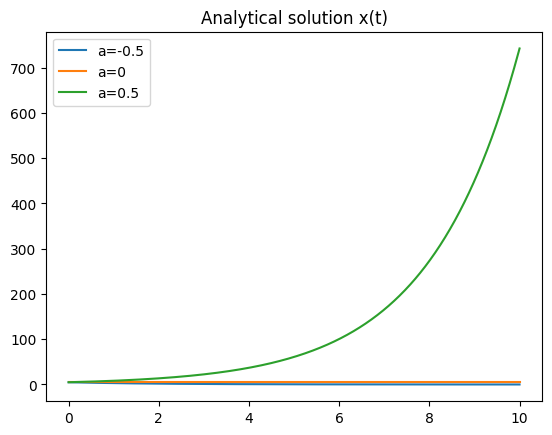

In [16]:
t = np.linspace(0, T, 1000)
X_t = analytical_solution(x_0, a_lst, t) # |a_lst| x len(t) array of x_t for different parameter a
t_broadcasted = np.broadcast_to(t, X_t.shape) # broadcast t to X_t shape for plotting
plt.plot(t_broadcasted.T, X_t.T)
plt.legend(list(map(lambda a: f'a={a}', a_lst)))
plt.title('Analytical solution x(t)')

#### 1.2 Opisz słownie trzy rodzaje zachowania układu dla parametru a w odpowiednich przedziałach.

*ODPOWIEDŹ*

DLa a > 0, układ wykazuje się wzrostem w tempie wykładniczym.
Dla a = 0, układ pozostaje niezmienny w czasie.
Dla a < 0, układ wykazuje zanik, im bardziej ujemna wartość parametru a, tym szybciej układ maleje.

Czy przebiegi z symulacji pasują do tych wyznaczonych analitycznie?

*ODPOWIEDŹ*

Tak, przebiegi z symulacji pokrywają się z tymi wyznaczonymi analitycznie, co świadczy o poprawności przeprowadzonej symulacji.

### Zadanie 2. Dopasowanie modelu do zjawiska
#### 2.1 Zakładając, że bateria nie jest ładowana, w jakim przedziale wartości musi znajdować się parametr $a$ żeby oddać typowe zachowanie baterii telefonu?

##### ODPOWIEDŹ

Parametr a musi znajdować się w przedziale a < 0 aby bateria telefonu zmniejszała się, tak jak typowa bateria telefonu, gdy nie jest podłączona do źródła ładowania.

#### 2.2 Biorąc pod uwagę wyniki z poprzedniego zadania oraz przebieg sygnału EEG, jakiego rodzaju odpowiedzi układu brakuje dla jednowymiarowego modelu liniowego przyjętego w zadaniu 1 aby oddać jakościowy przebieg sygnału EEG z poniższego rysunku?

##### ODPOWIEDŹ

Aby oddać jakościowy przebieg sygnału EEG z poniższego rysunku, trzeba by uwzględnić szumy i impulsy o dużych amplitudach jak na wykresie poniżej. Trzeba również by wprowadzić
nieliniowość aby odpowiednio oddać zachowanie sygnału EEG i uwzględnić oscylacje.

![Picture title](image-20221212-160524.png)
Źródło: https://biomedpharmajournal.org/vol10no4/wavelet-transform-for-classification-of-eeg-signal-using-svm-and-ann/

### Zadanie 3. Dopasowanie sterowania dla układu z wejściem

Dla układów w pełni pobudzonych (np. o osobnym wejściu dla każdego elementu wektora stanu), możliwe jest nadpisanie dynamiki układu względem własnego uznania (np. odwrócenie grawitacji dla wahadła). W zadaniu 3 zaprojektujemy sterownik niwelujący dynamikę układu a następnie sterownik, który wytworzy okresową odpowiedź układu.

In [17]:
# Symulacja układu z pobudzeniem

# x_dot = ax + u
class Linear1DWithInput(LeafSystem):
    def __init__(self, a):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)  # One state variable.
        self.input = self.DeclareVectorInputPort("u", 1)
        self.a = a
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        u = self.input.Eval(context)
        xdot = self.a * x + u
        derivatives.get_mutable_vector().SetAtIndex(0, xdot)


def create_system_with_input(x_0, a, controller):
    def plot():
        log = logger.FindLog(context)
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('x(t)')

    builder = DiagramBuilder()

    system = builder.AddSystem(Linear1DWithInput(a))
    logger = LogVectorOutput(system.get_output_port(), builder)

    controller = builder.AddSystem(controller)

    builder.Connect(controller.get_output_port(), system.get_input_port())
    builder.Connect(system.get_output_port(), controller.get_input_port())

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    context.SetContinuousState(np.array([x_0]))
    return diagram, context, plot, system

x_0 = 5.0
a = -0.2
T = 100

#### 3.1 Kompensacja dynamiki: ustaw sterowanie tak aby na wyjściu był stały sygnał $x_0$

In [18]:
class DummyController(LeafSystem):
    def __init__(self, a):
        LeafSystem.__init__(self)

        self.a = a
        self.input = self.DeclareVectorInputPort("x", 1)
        self.output = self.DeclareVectorOutputPort("y", 1, self.control)

    def control(self, context, output):
        x = self.input.Eval(context)
        t = context.get_time()
        u = 0.0
        output.get_mutable_value()[:] = u

controller = DummyController(a)
diagram, context, plot, system = create_system_with_input(x_0, a, controller)

/tmp/ipykernel_5309/2771263847.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  derivatives.get_mutable_vector().SetAtIndex(0, xdot)


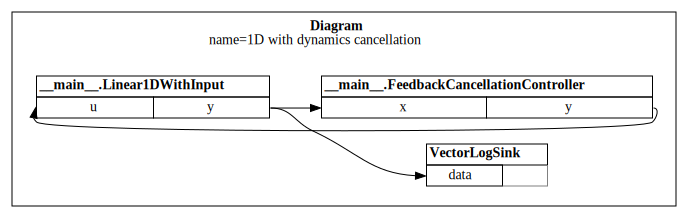

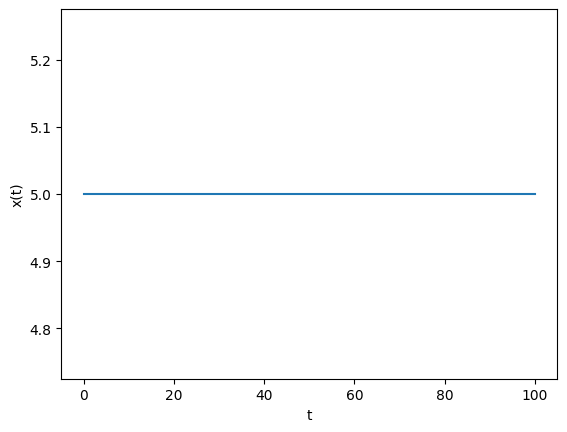

In [19]:
class FeedbackCancellationController(LeafSystem):
    def __init__(self, a):
        LeafSystem.__init__(self)

        self.a = a
        self.input = self.DeclareVectorInputPort("x", 1)
        self.output = self.DeclareVectorOutputPort("y", 1, self.control)

    def control(self, context, output):
        x = self.input.Eval(context)
        t = context.get_time()
        u = -self.a * x # TODO: Ustaw odpowiednią wartość sterowania
        output.get_mutable_value()[:] = u

controller = FeedbackCancellationController(a)
diagram, context, plot, system = create_system_with_input(x_0, a, controller)
simulator = Simulator(diagram, context)
simulator.AdvanceTo(T)
plot()
diagram.set_name("1D with dynamics cancellation")
display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

#### 3.2 Sygnał okresowy na wyjściu układu: dopasuj sterowanie tak aby na wyjściu uzyskać sygnał $x_o + sin(t)$

/tmp/ipykernel_5309/2771263847.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  derivatives.get_mutable_vector().SetAtIndex(0, xdot)


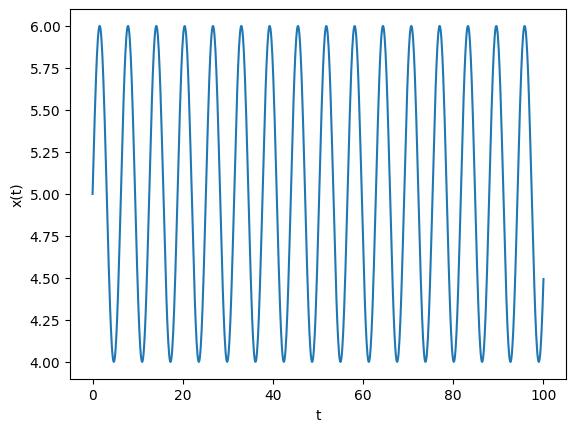

In [20]:
class PeriodicOutputController(LeafSystem):
    def __init__(self, a):
        LeafSystem.__init__(self)

        self.a = a
        self.input = self.DeclareVectorInputPort("x", 1)
        self.output = self.DeclareVectorOutputPort("y", 1, self.control)

    def control(self, context, output):
        x = self.input.Eval(context)
        t = context.get_time()
        u = -self.a * x + np.cos(t)# TODO: Ustaw odpowiednią wartość sterowania
        output.get_mutable_value()[:] = u

controller = PeriodicOutputController(a)
diagram, context, plot, system = create_system_with_input(x_0, a, controller)
simulator = Simulator(diagram, context)
simulator.AdvanceTo(T)
plot()

#### 3.3 Wpływ ograniczeń regulatora na nadpisanie dynamiki
Przeanalizuj wykresy wygenerowane dla różnych wartości stanu początkowego $x_0$ oraz ograniczenia sterowanie $|u| \le u_{lim}$.

Jak ograniczenie sterowania wpływa na zdolność nadpisania dynamiki obiektu?

*ODPOWIEWDŹ*

Im bardziej ograniczenie sterowania jest mniejsze, tym ciężej będzie zmienić trajektorię obiektu. Gdy u_{lim}$ jest zbyt małe, sterowanie może być niedostateczne, aby skutecznie reagować na zmiany dynamiki obiektu.

Jak obniżenie stanu początkowego $x_0$ wpływa na powyższą zależność?

*ODPOWIEDŹ*

Pozwala na obniżenie wymaganych sił sterujących, potrzebnych do reakcji na zmieniającą się dynamikę obiektu.

/tmp/ipykernel_5309/2771263847.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  derivatives.get_mutable_vector().SetAtIndex(0, xdot)


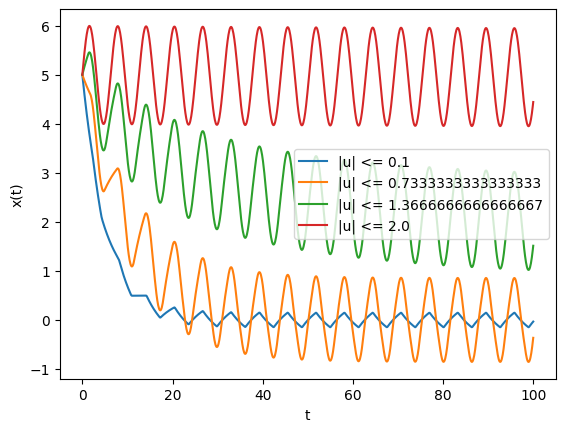

In [21]:
class Controller(LeafSystem):
    def __init__(self, a, u_lim):
        LeafSystem.__init__(self)

        self.a = a
        self.u_lim = u_lim
        self.input = self.DeclareVectorInputPort("x", 1)
        self.output = self.DeclareVectorOutputPort("y", 1, self.control)

    def control(self, context, output):
        x = self.input.Eval(context)
        t = context.get_time()
        u = -self.a * x + np.cos(t) # Ustaw takie samo sterowanie jak w PeriodicOutputController

        # NIE ZMIENIAĆ
        u = np.clip(u, -self.u_lim, self.u_lim)
        output.get_mutable_value()[:] = u

x_0 = 5.0
u_lim_lst = np.linspace(0.1, 2, 4)
for u_lim in u_lim_lst:
    controller = Controller(a, u_lim)
    diagram, context, plot, system = create_system_with_input(x_0, a, controller)
    simulator = Simulator(diagram, context)
    simulator.AdvanceTo(T)
    plot()
plt.legend(list(map(lambda u_lim: f'|u| <= {u_lim}', u_lim_lst)))

/tmp/ipykernel_5309/2771263847.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  derivatives.get_mutable_vector().SetAtIndex(0, xdot)


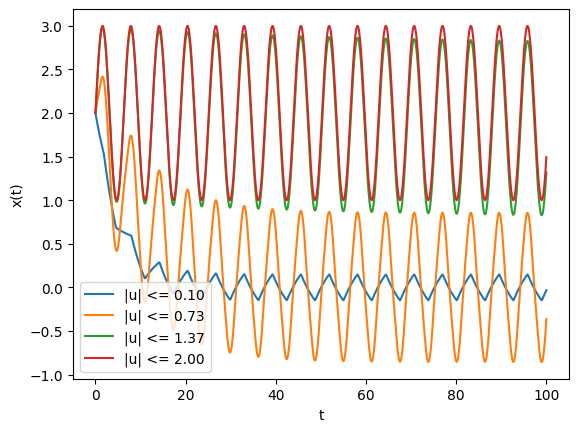

In [22]:
x_0 = 2.0
u_lim_lst = np.linspace(0.1, 2, 4)
for u_lim in u_lim_lst:
    controller = Controller(a, u_lim)
    diagram, context, plot, system = create_system_with_input(x_0, a, controller)
    simulator = Simulator(diagram, context)
    simulator.AdvanceTo(T)
    plot()
plt.legend(list(map(lambda u_lim: f'|u| <= {u_lim:.2f}', u_lim_lst)))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2df761c6-4985-476e-8b15-82c06c29c7b5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>